# Hourly Electricity Consumption and Production

### About Dataset
Hourly Electricity Consumption and Production by Type in Romania for 5.5 years. <br>
It includes the hourly consumption and production, and the production is split in one of the categories: Nuclear, Wind, Hydroelectric, Oil and Gas, Coal, Solar, Biomass.
When the production is greater than the consumption it means we are exporting electricity, when the value is smaller it means we are importing electricity.

All values are in MWs.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from pandas.plotting import autocorrelation_plot

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
#import the dataset
df = pd.read_csv("electricity.csv")

#first five rows
df.head()

,DateTime,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
0,2019-01-01 00:00:00,6352,6527,1395,79,1383,1896,1744,0,30
1,2019-01-01 01:00:00,6116,5701,1393,96,1112,1429,1641,0,30
2,2019-01-01 02:00:00,5873,5676,1393,142,1030,1465,1616,0,30
3,2019-01-01 03:00:00,5682,5603,1397,191,972,1455,1558,0,30
4,2019-01-01 04:00:00,5557,5454,1393,159,960,1454,1458,0,30


In [3]:
#dimensions of the dataset
df.shape

(46011, 10)

In [4]:
#general info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46011 entries, 0 to 46010
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   DateTime       46011 non-null  object
 1   Consumption    46011 non-null  int64 
 2   Production     46011 non-null  int64 
 3   Nuclear        46011 non-null  int64 
 4   Wind           46011 non-null  int64 
 5   Hydroelectric  46011 non-null  int64 
 6   Oil and Gas    46011 non-null  int64 
 7   Coal           46011 non-null  int64 
 8   Solar          46011 non-null  int64 
 9   Biomass        46011 non-null  int64 
dtypes: int64(9), object(1)
memory usage: 3.5+ MB


In [5]:
#null values??
df.isna().sum()

DateTime         0
Consumption      0
Production       0
Nuclear          0
Wind             0
Hydroelectric    0
Oil and Gas      0
Coal             0
Solar            0
Biomass          0
dtype: int64

In [6]:
#duplicates??
df.duplicated().sum()

4

In [7]:
#drop duplicates
df.drop_duplicates(inplace=True)

In [8]:
# descriptive statistics
df.describe()

,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
count,46007.000000,46007.000000,46007.000000,46007.000000,46007.000000,46007.000000,46007.000000,46007.000000,46007.000000
mean,6587.748821,6518.769013,1291.168257,792.337449,1857.125959,1171.915122,1193.151760,156.701654,55.851827
std,1043.599203,986.752998,236.557773,675.823462,692.574677,434.752299,320.457227,229.507977,14.236068
min,3889.000000,3315.000000,562.000000,-26.000000,175.000000,198.000000,279.000000,0.000000,17.000000
25%,5773.000000,5814.000000,1347.000000,236.000000,1347.000000,858.000000,962.000000,0.000000,45.000000
50%,6552.000000,6462.000000,1383.000000,592.000000,1747.000000,1211.000000,1172.000000,2.000000,57.000000
75%,7321.000000,7176.000000,1405.000000,1205.000000,2265.000000,1511.000000,1406.000000,280.500000,67.000000
max,9615.000000,9886.000000,1457.000000,2811.000000,4434.000000,2141.000000,2537.000000,1137.000000,89.000000


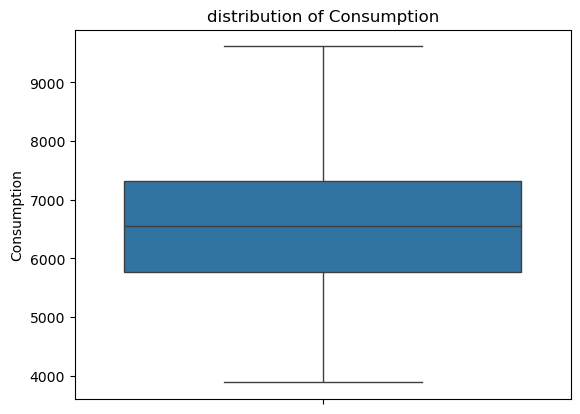

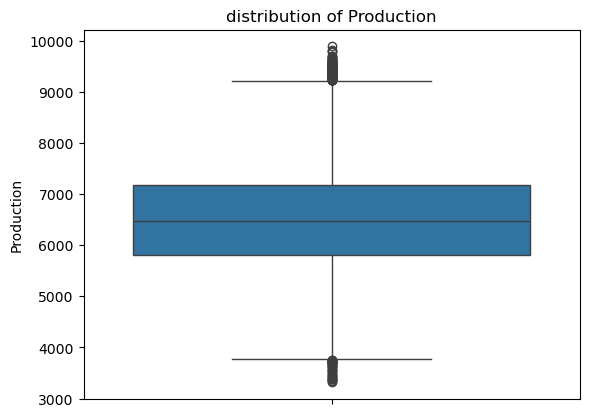

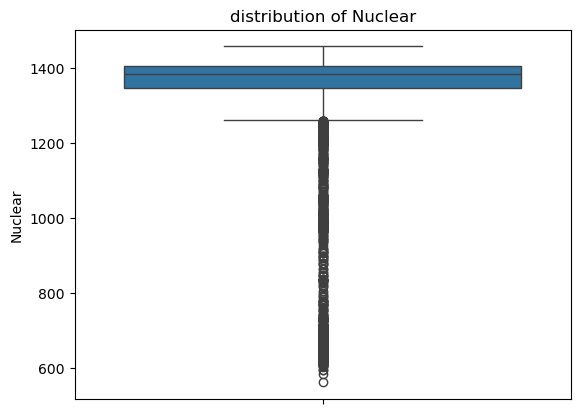

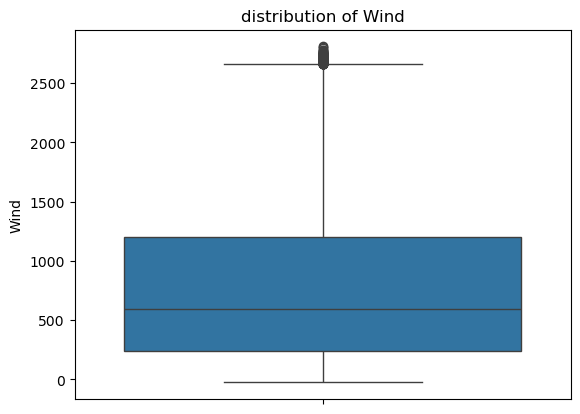

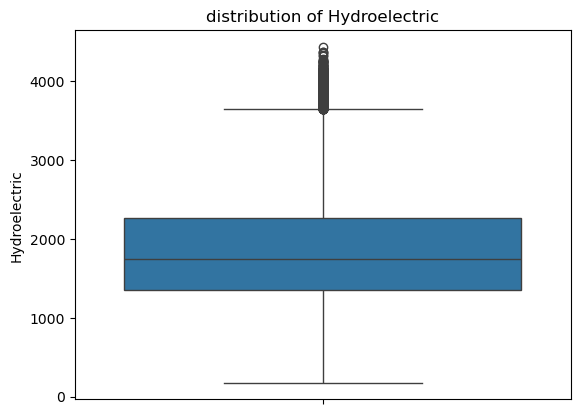

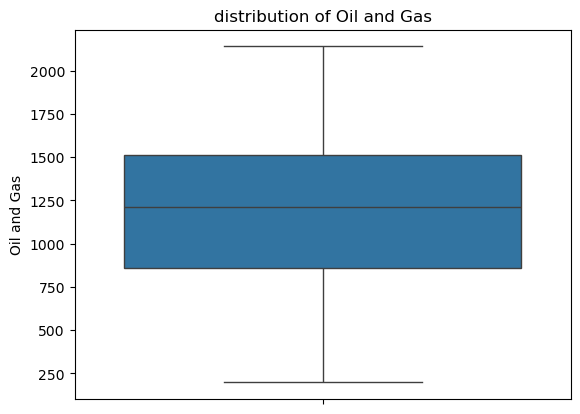

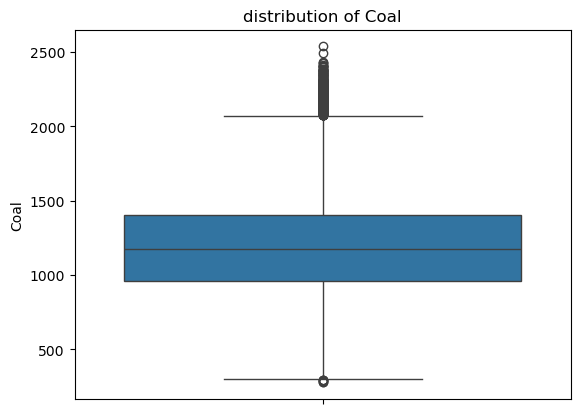

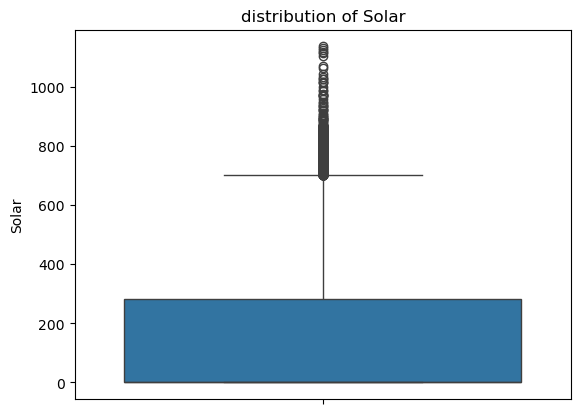

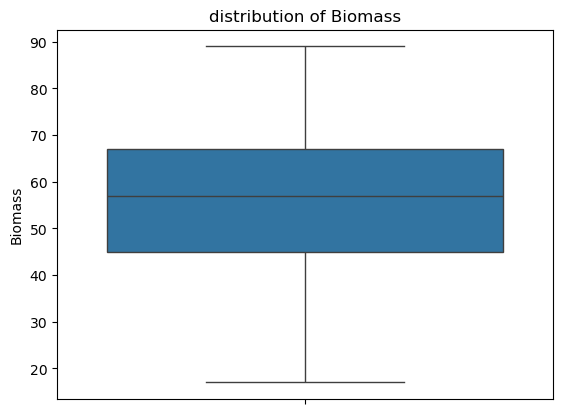

In [9]:
#outliers??
for o in df.select_dtypes(include=['int']):
    plt.figure()
    sns.boxplot(df[o])
    plt.title(f'distribution of {o}')
    plt.show()

<Axes: >

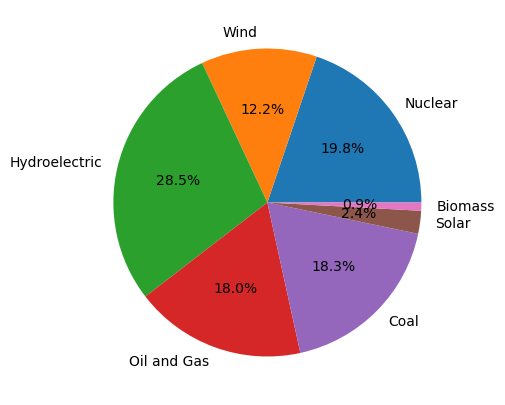

In [10]:
# Contribution in % by energy source in the Total production 
total_production = df[['Nuclear','Wind','Hydroelectric','Oil and Gas','Coal','Solar','Biomass']].sum()
plt.figure(figsize=(15,5))
total_production.plot.pie(autopct = '%1.1f%%')

In [11]:
#convert DateTime to a datetime object
df['DateTime'] = pd.to_datetime(df['DateTime'])

#create Export/Import column Remember: 
#When the production is greaterthan the consumption it means we are exporting electricity, when the value is smaller it means we are importing electricity
def export_import(df):
    if df['Production'] > df['Consumption']:
        return 'Export'
    else:
        return 'Import'
df['Export/Import'] = df.apply(export_import, axis=1)

<Axes: ylabel='count'>

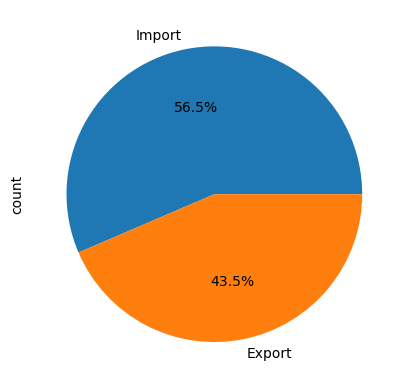

In [12]:
#The proportion of Export and Import 
df['Export/Import'].value_counts().plot.pie(autopct='%1.1f%%')

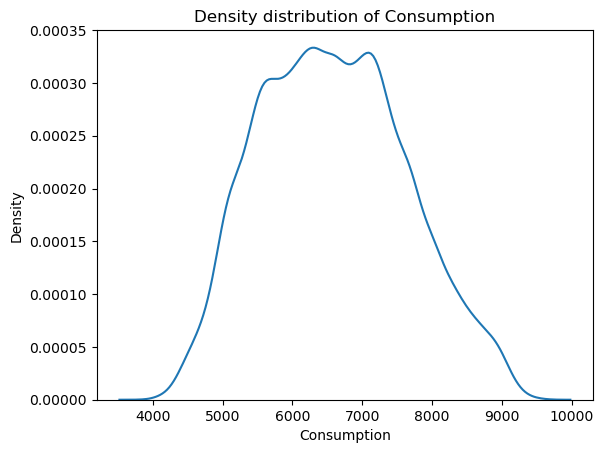

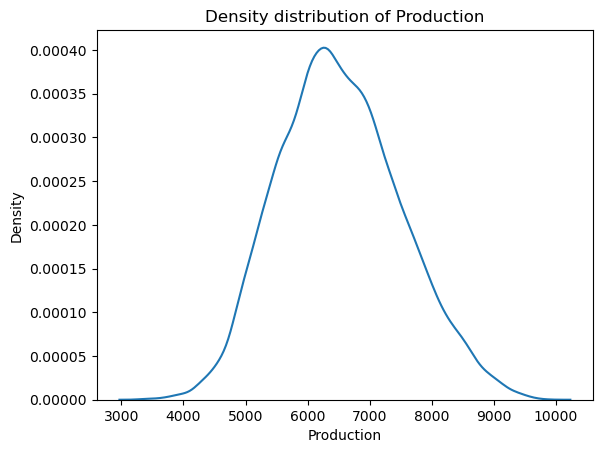

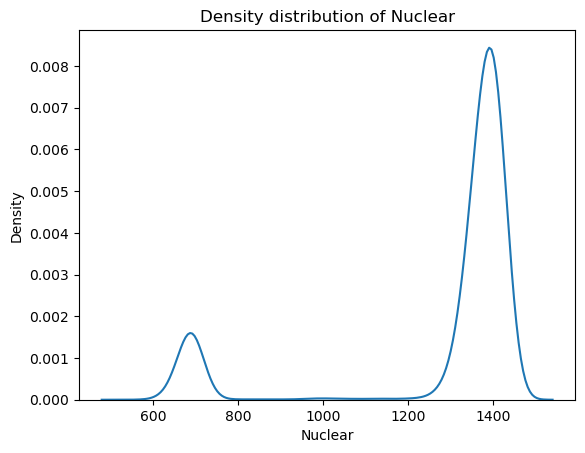

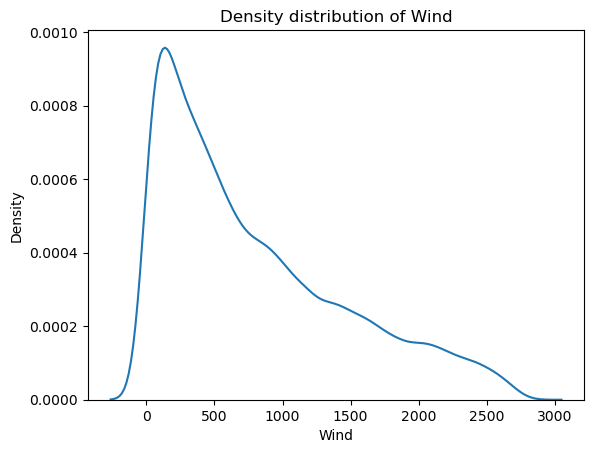

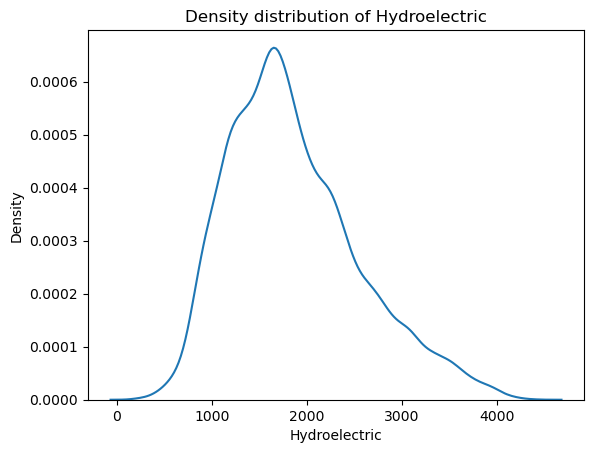

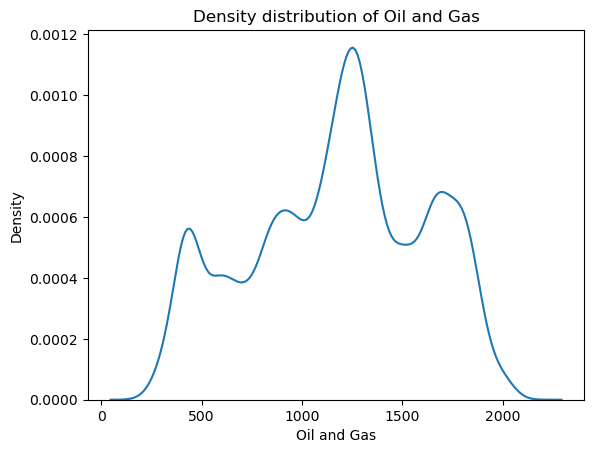

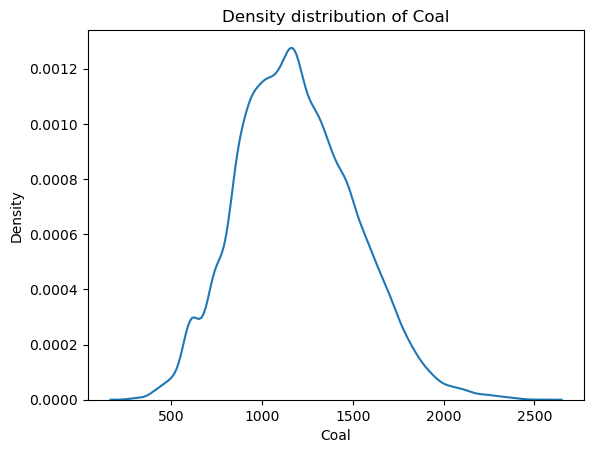

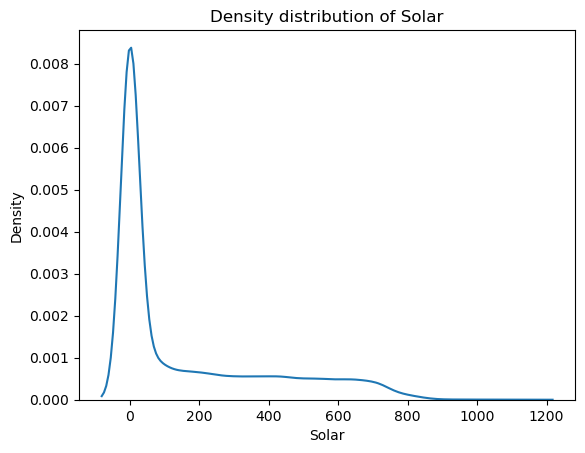

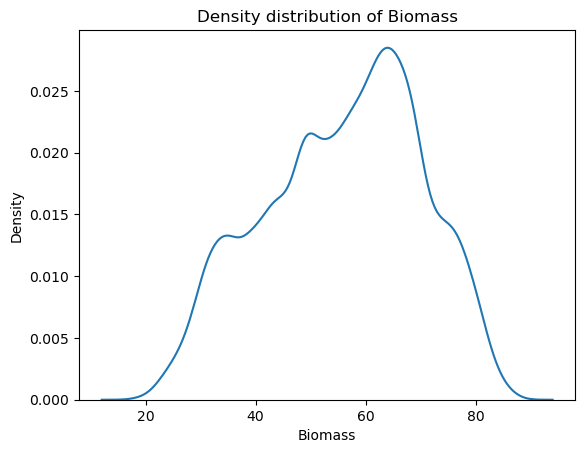

In [13]:
#kernel density of variables
for d in df.select_dtypes(include=['int']):
    plt.figure()
    sns.kdeplot(df[d])
    plt.title(f'Density distribution of {d}')
    plt.show()

In [14]:
#Create Hour, Day, Month, Year columns from DateTime
df['Hour'] = df['DateTime'].dt.hour
df['Day'] = df['DateTime'].dt.day
df['Month'] = df['DateTime'].dt.month
df['Year'] = df['DateTime'].dt.year

C:\Users\dell\AppData\Local\Temp\ipykernel_15144\521992894.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(25,15))


<Figure size 2500x1500 with 0 Axes>

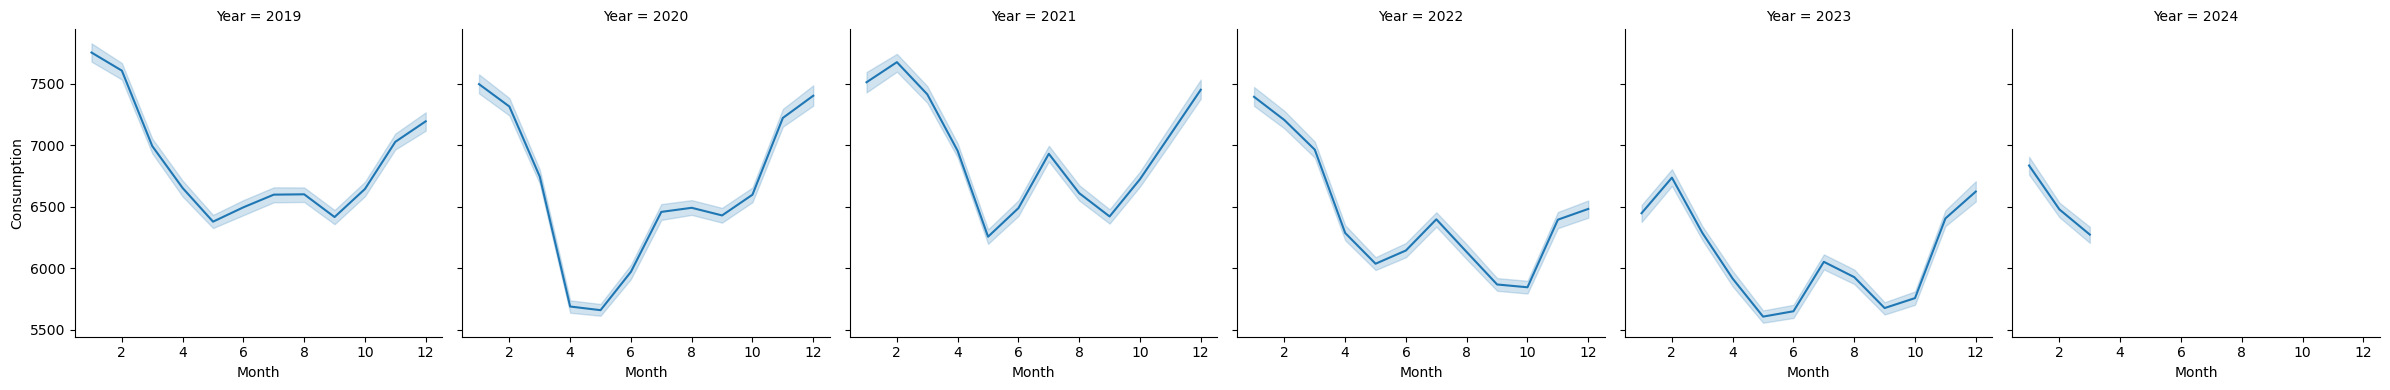

<Figure size 2500x1500 with 0 Axes>

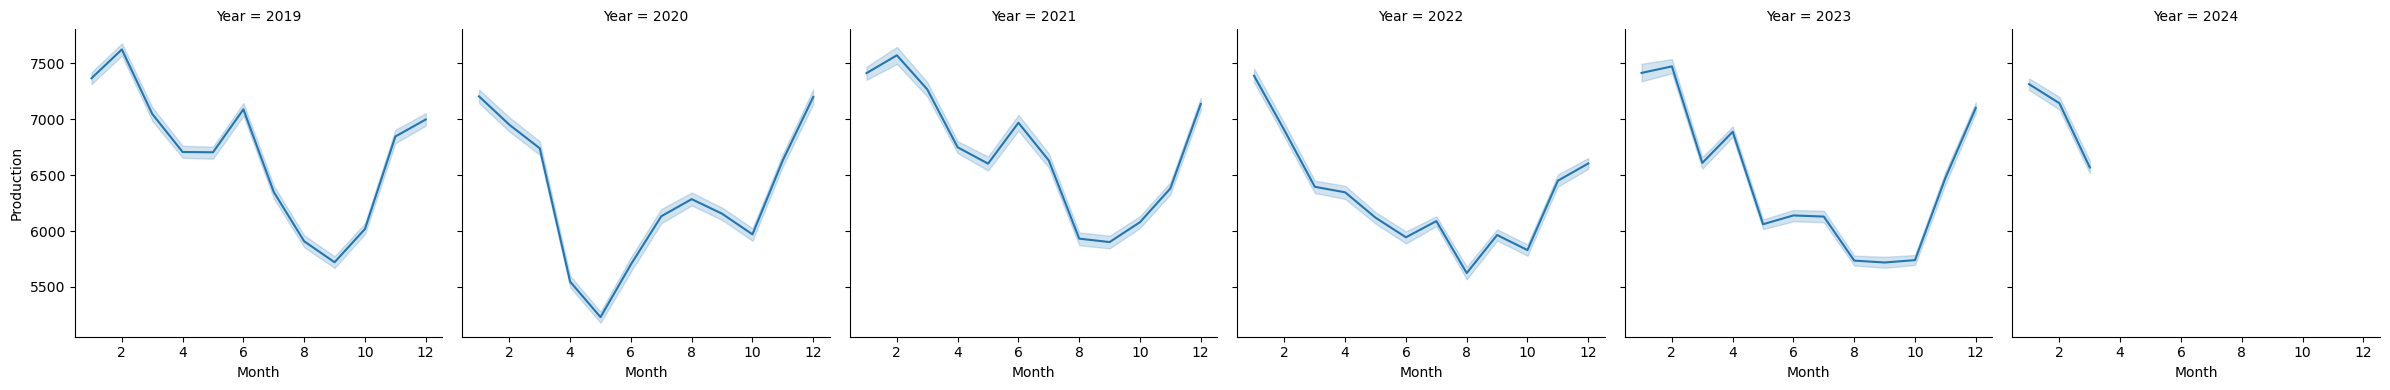

<Figure size 2500x1500 with 0 Axes>

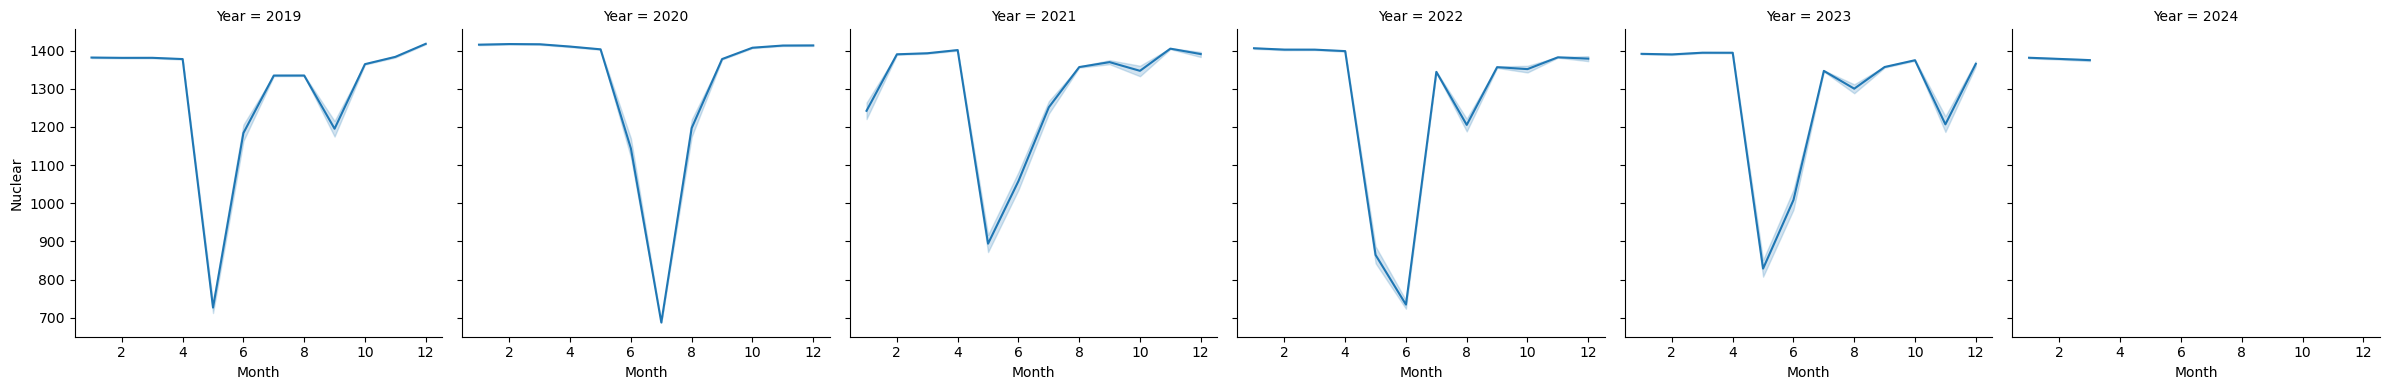

<Figure size 2500x1500 with 0 Axes>

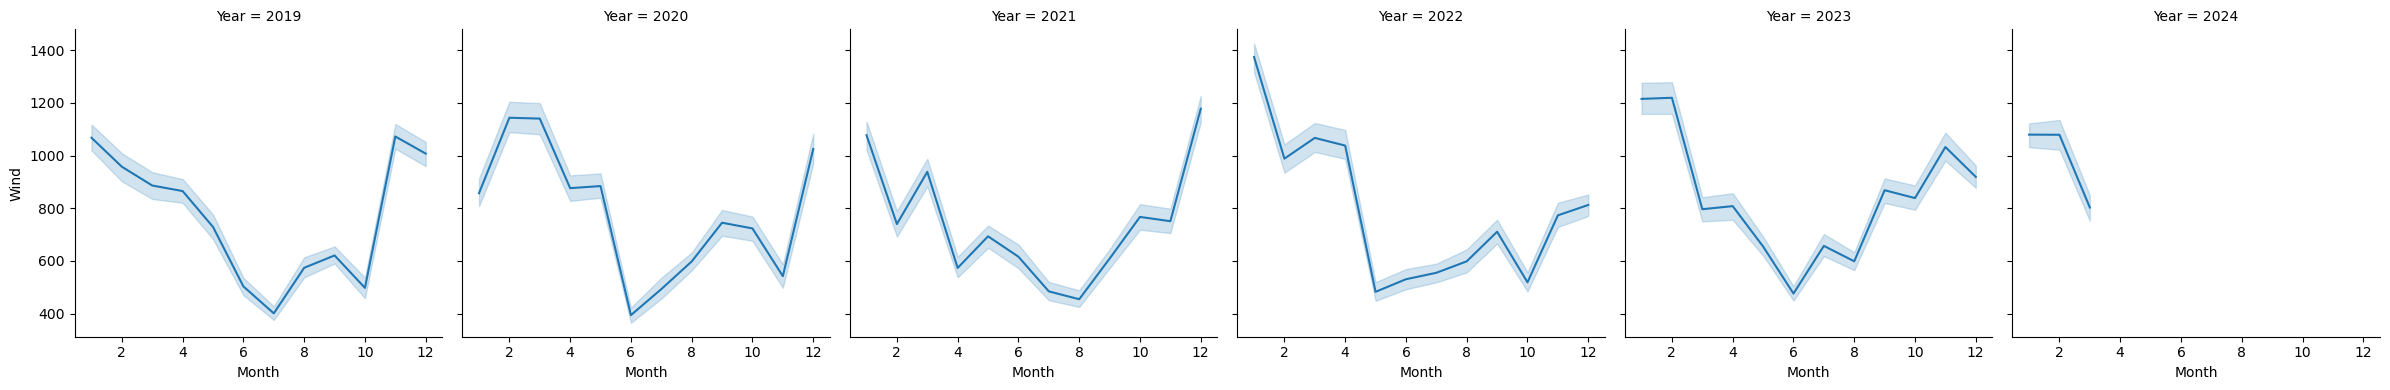

<Figure size 2500x1500 with 0 Axes>

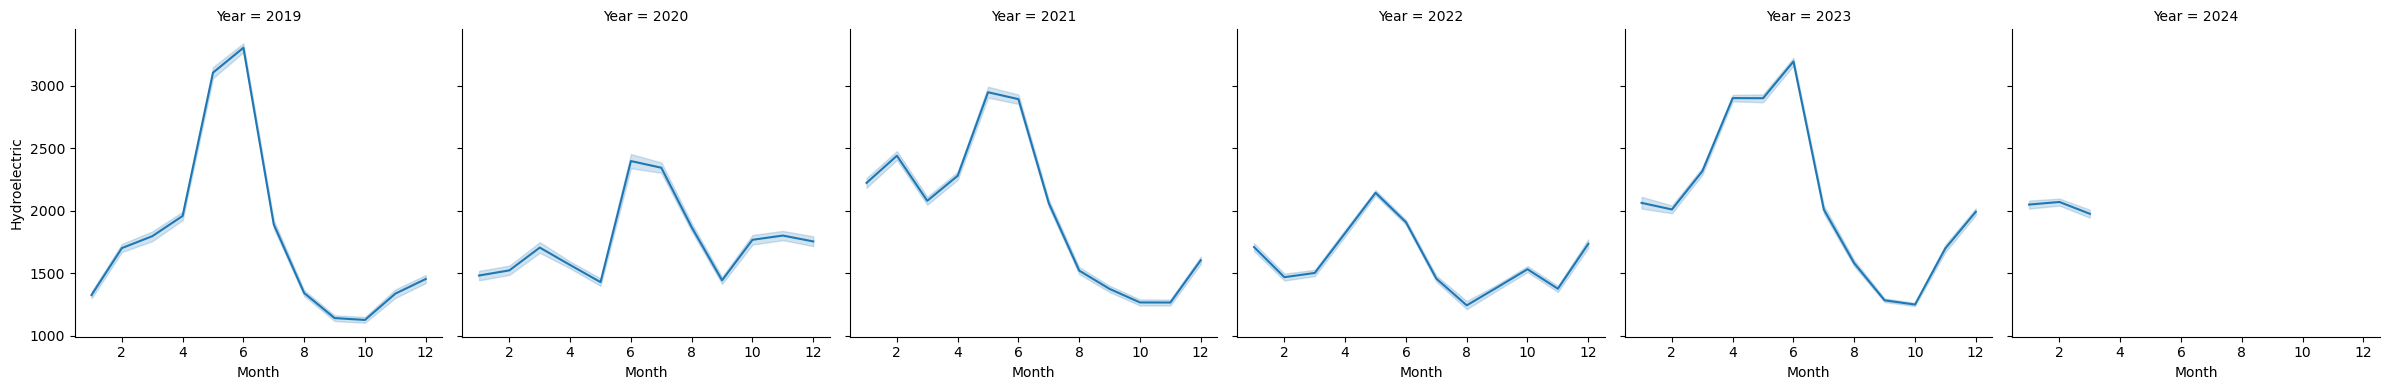

<Figure size 2500x1500 with 0 Axes>

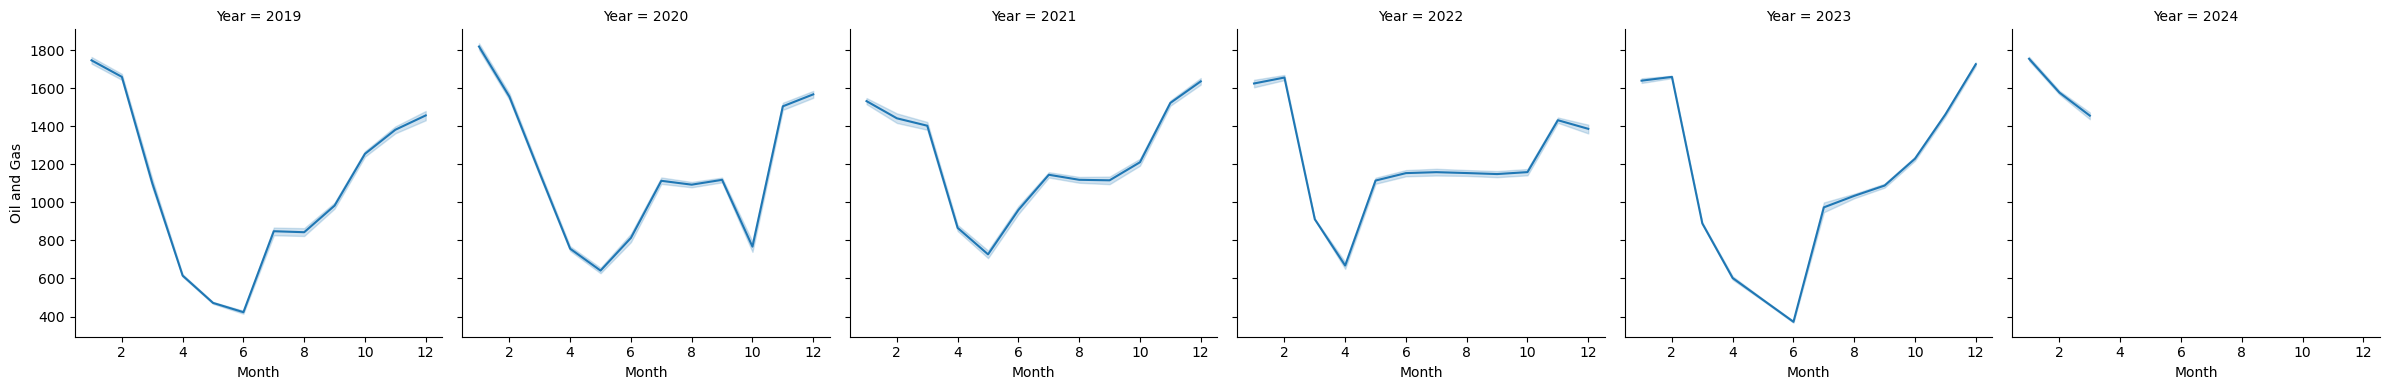

<Figure size 2500x1500 with 0 Axes>

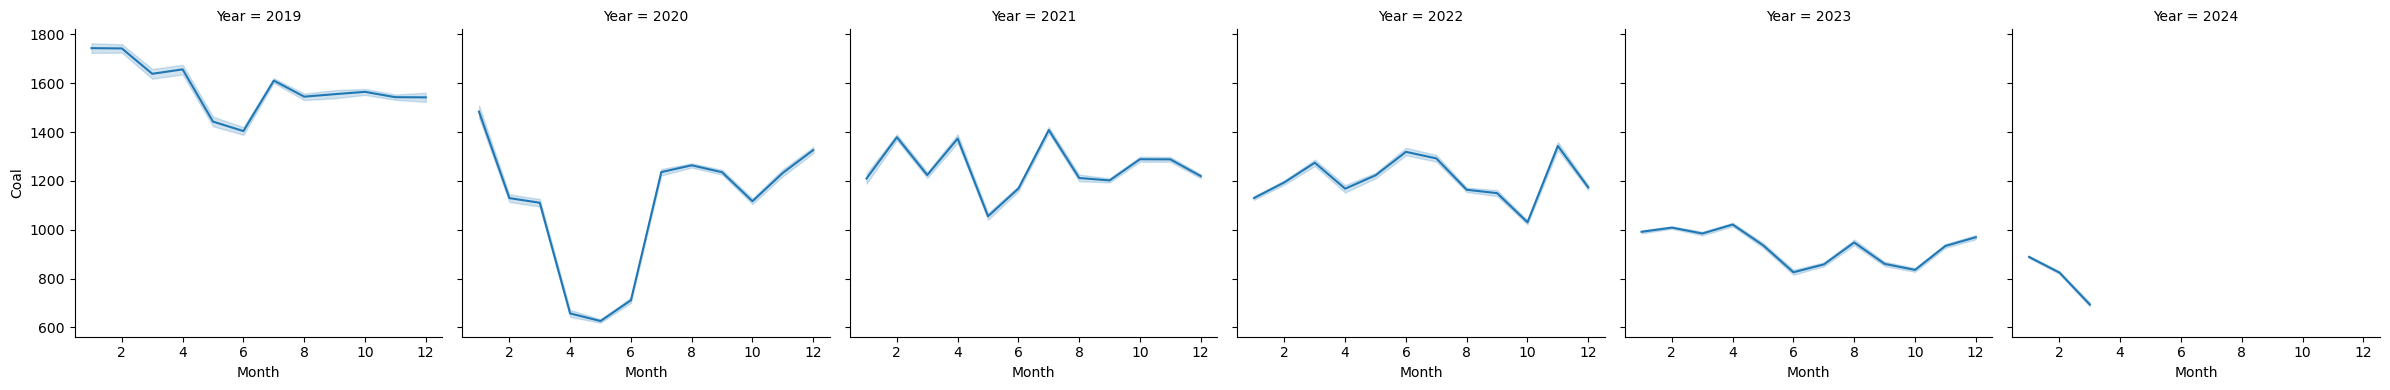

<Figure size 2500x1500 with 0 Axes>

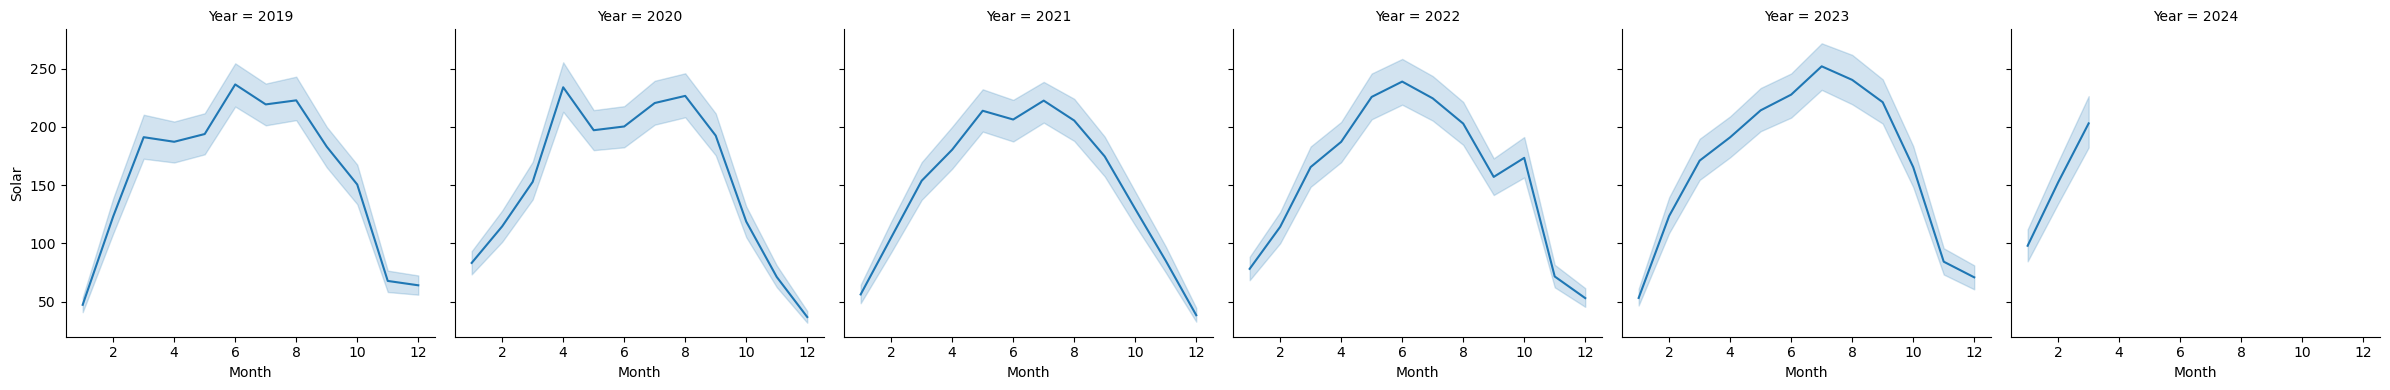

<Figure size 2500x1500 with 0 Axes>

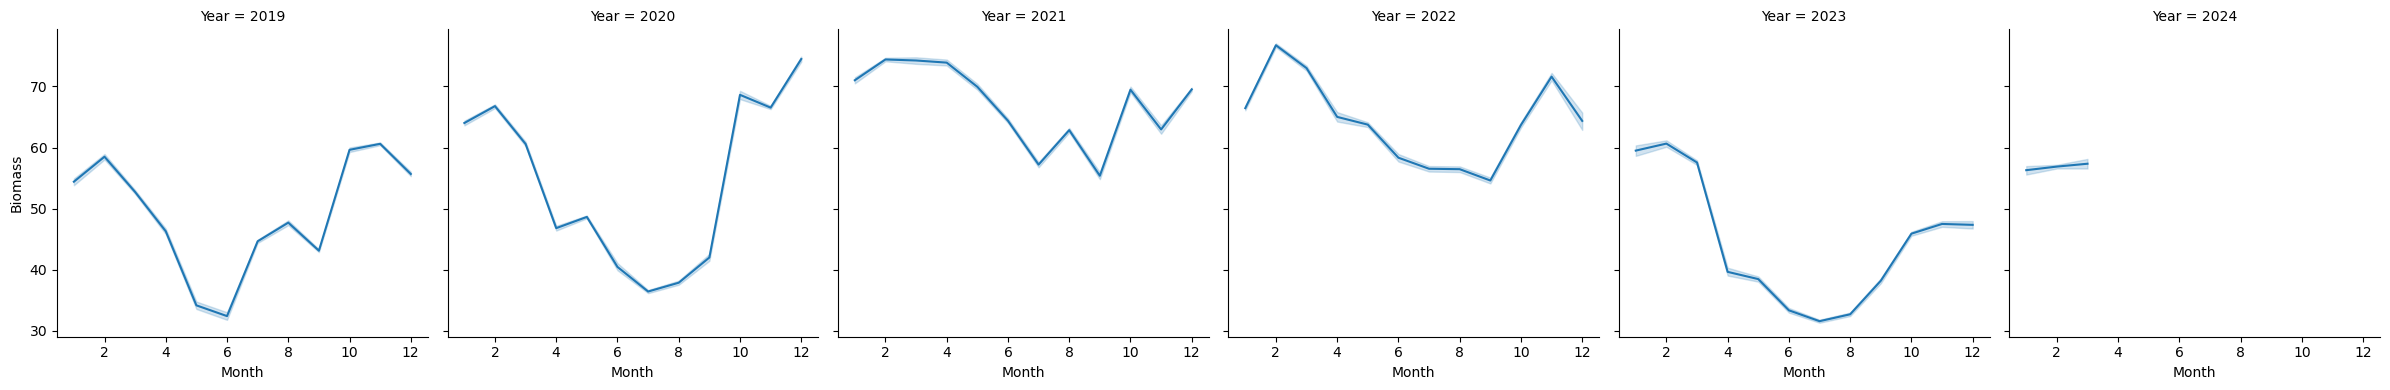

<Figure size 2500x1500 with 0 Axes>

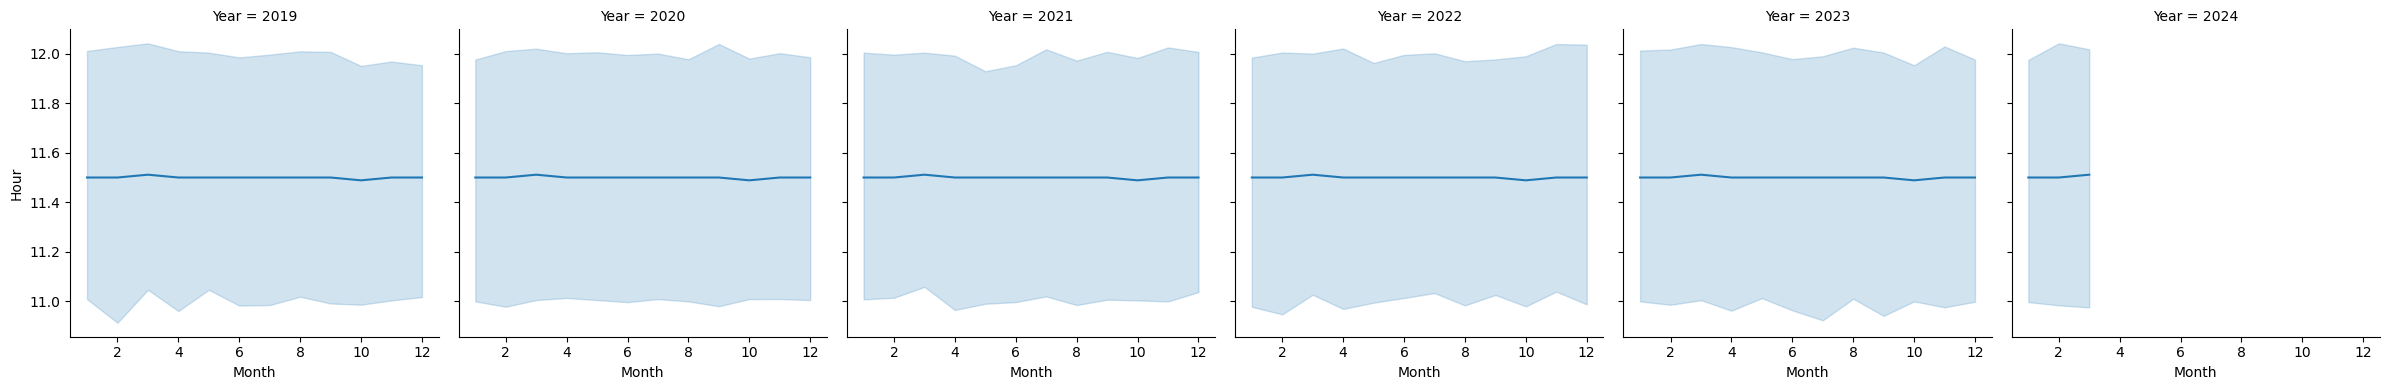

<Figure size 2500x1500 with 0 Axes>

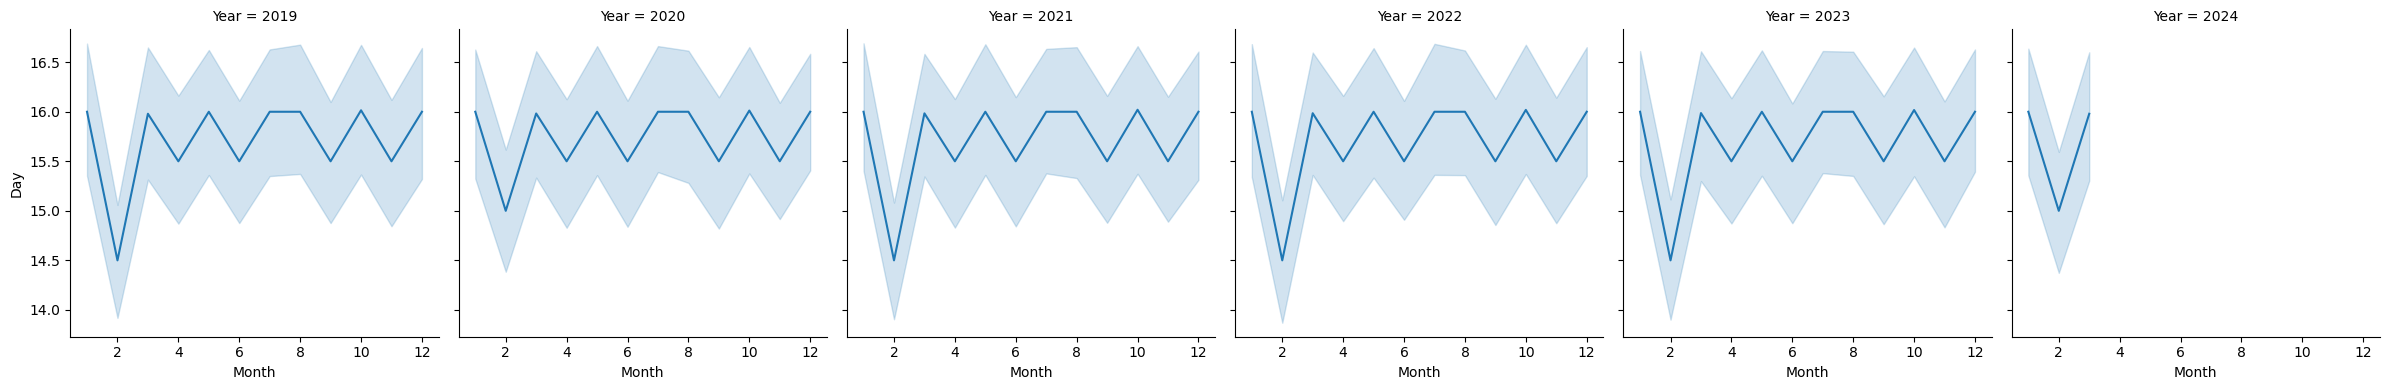

<Figure size 2500x1500 with 0 Axes>

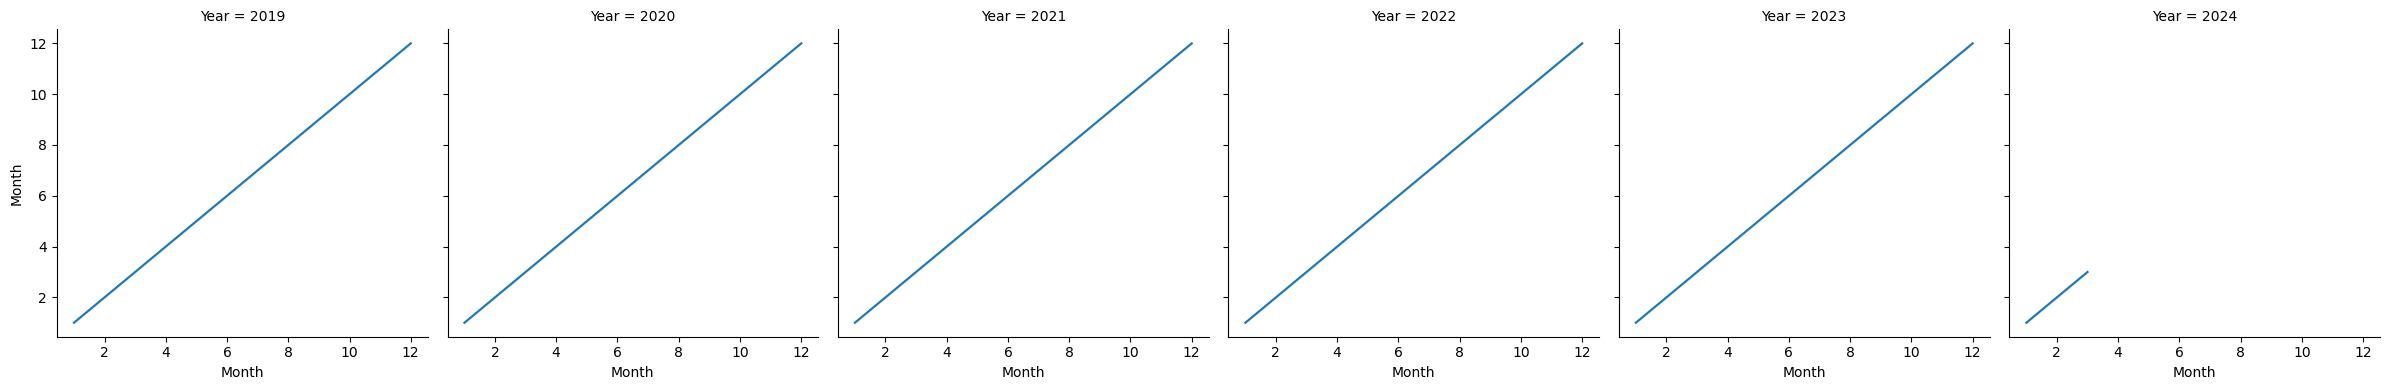

<Figure size 2500x1500 with 0 Axes>

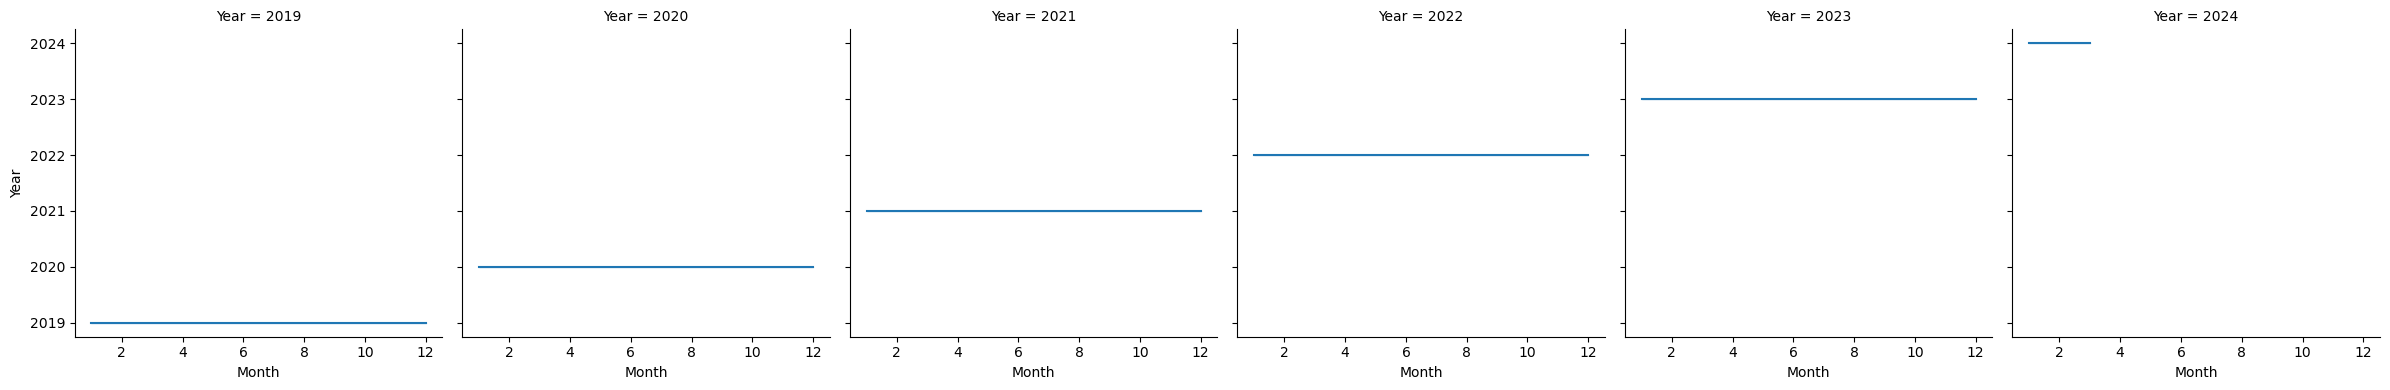

In [15]:
#see seasonality based on Month and Year
for t in df.select_dtypes(include=['int']):
    plt.figure(figsize=(25,15))
    g = sns.FacetGrid(df, col='Year', col_wrap=6, height=4)
    g.map(sns.lineplot, 'Month', t)

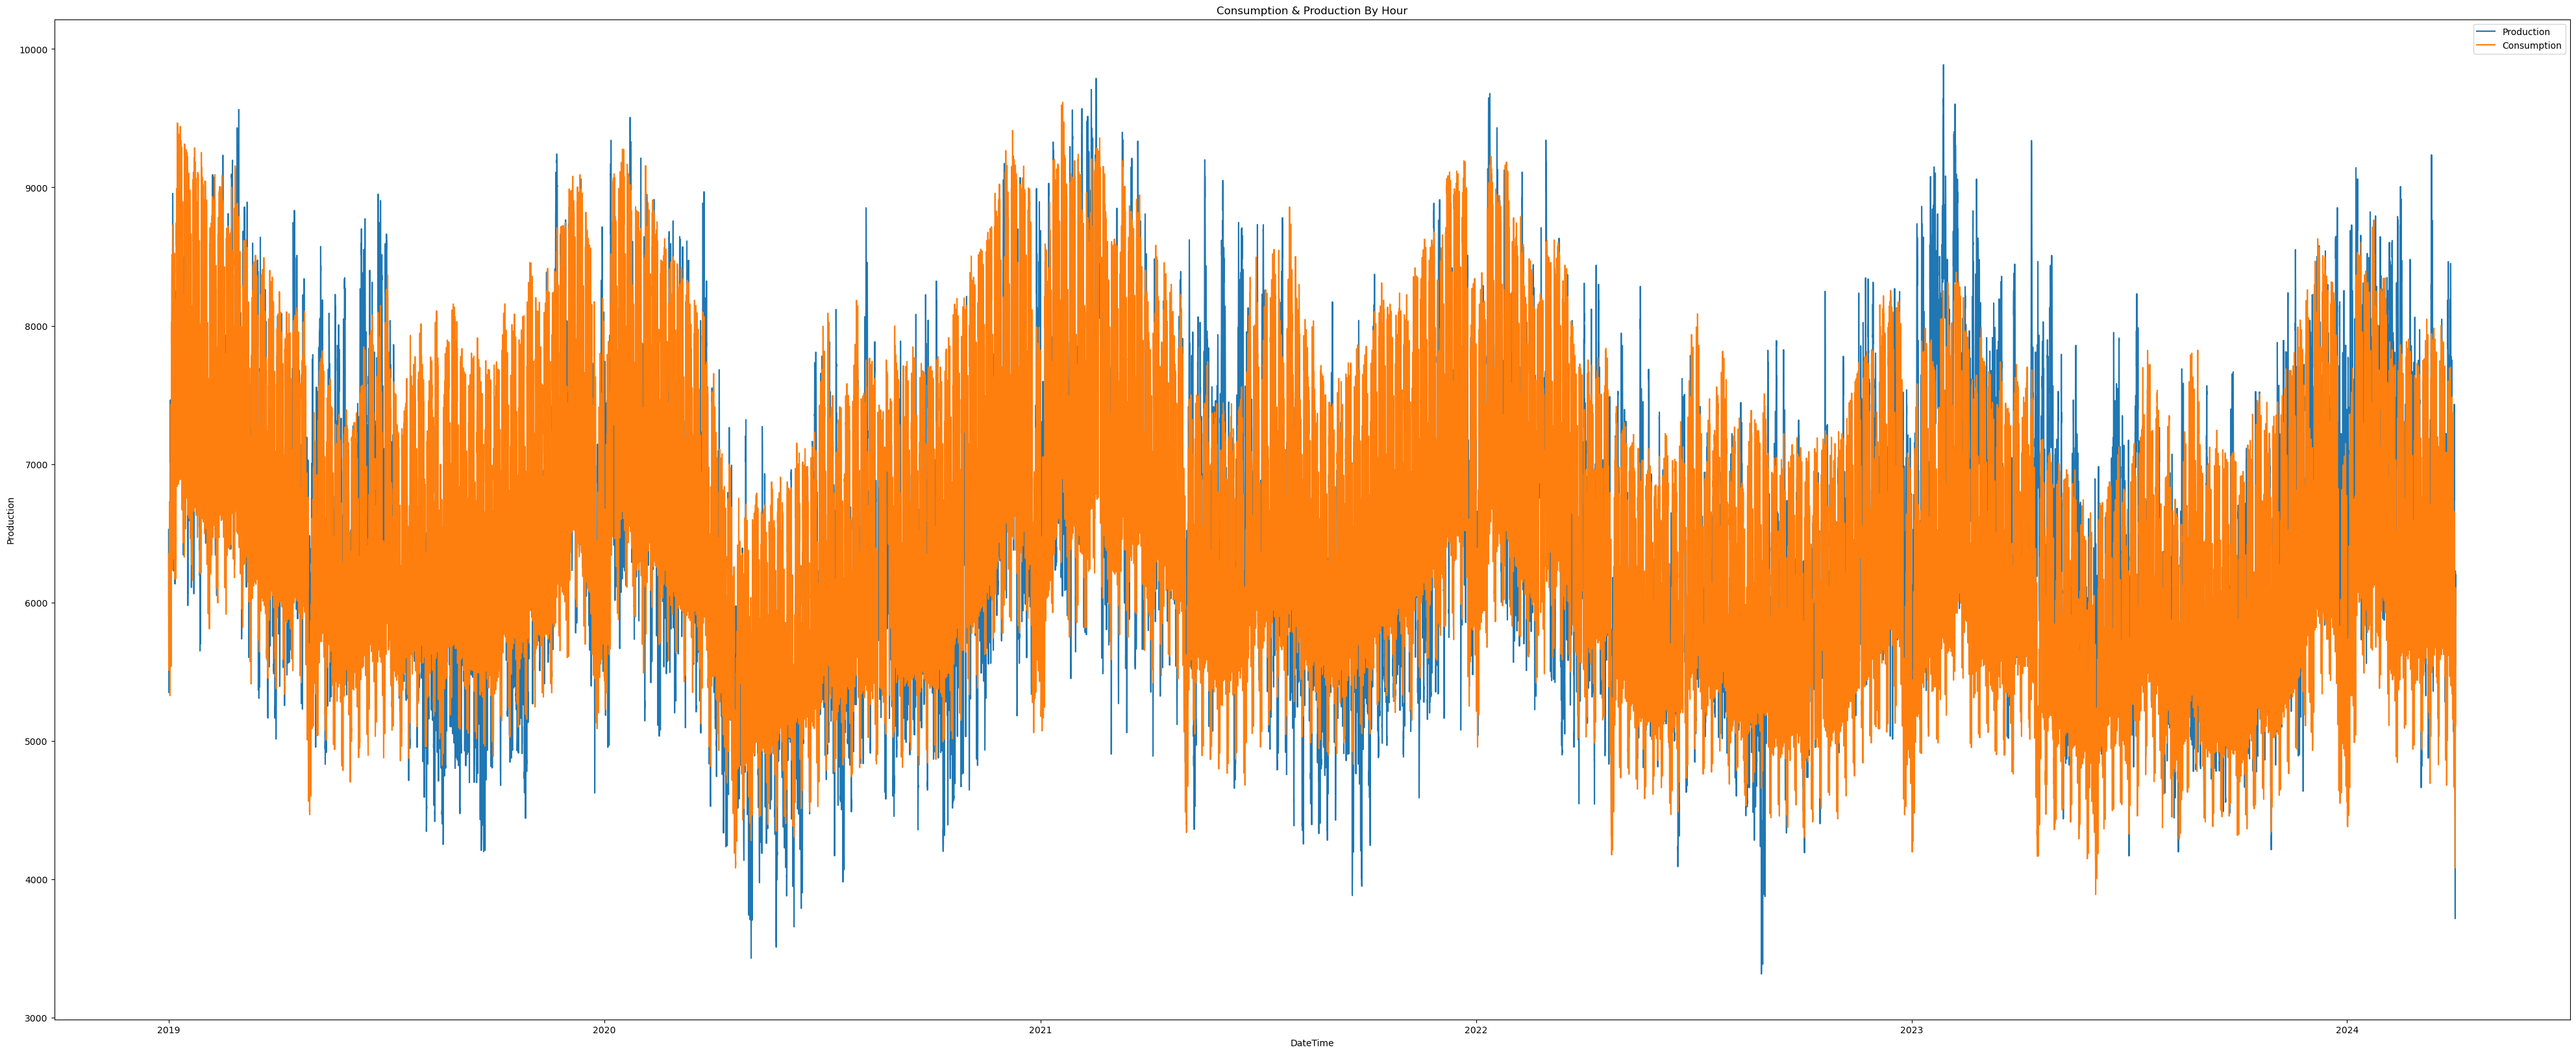

In [16]:
#Consumption & Production By Hour
plt.figure(figsize=(50,20))
sns.lineplot(x='DateTime',y='Production',data=df, label='Production')
sns.lineplot(x='DateTime',y='Consumption',data=df, label='Consumption')
plt.title('Consumption & Production By Hour')
plt.legend()


In [17]:
#Mean Production by month
df.groupby('Month')['Production'].mean().sort_values(ascending=False)


Month
1     7351.026434
2     7275.392402
12    7008.483065
3     6771.992822
11    6557.603611
4     6447.891389
6     6369.139722
7     6266.634409
5     6144.019355
10    5927.908725
8     5897.455376
9     5892.503056
Name: Production, dtype: float64

In [18]:
#Mean Consumption by month
df.groupby('Month')['Consumption'].mean().sort_values(ascending=False)

Month
1     7239.078629
2     7165.422794
12    7030.345161
11    6827.142778
3     6779.522880
7     6487.788710
8     6353.122581
10    6314.409128
4     6300.157500
9     6163.162500
6     6150.920278
5     5988.722581
Name: Consumption, dtype: float64

<Axes: >

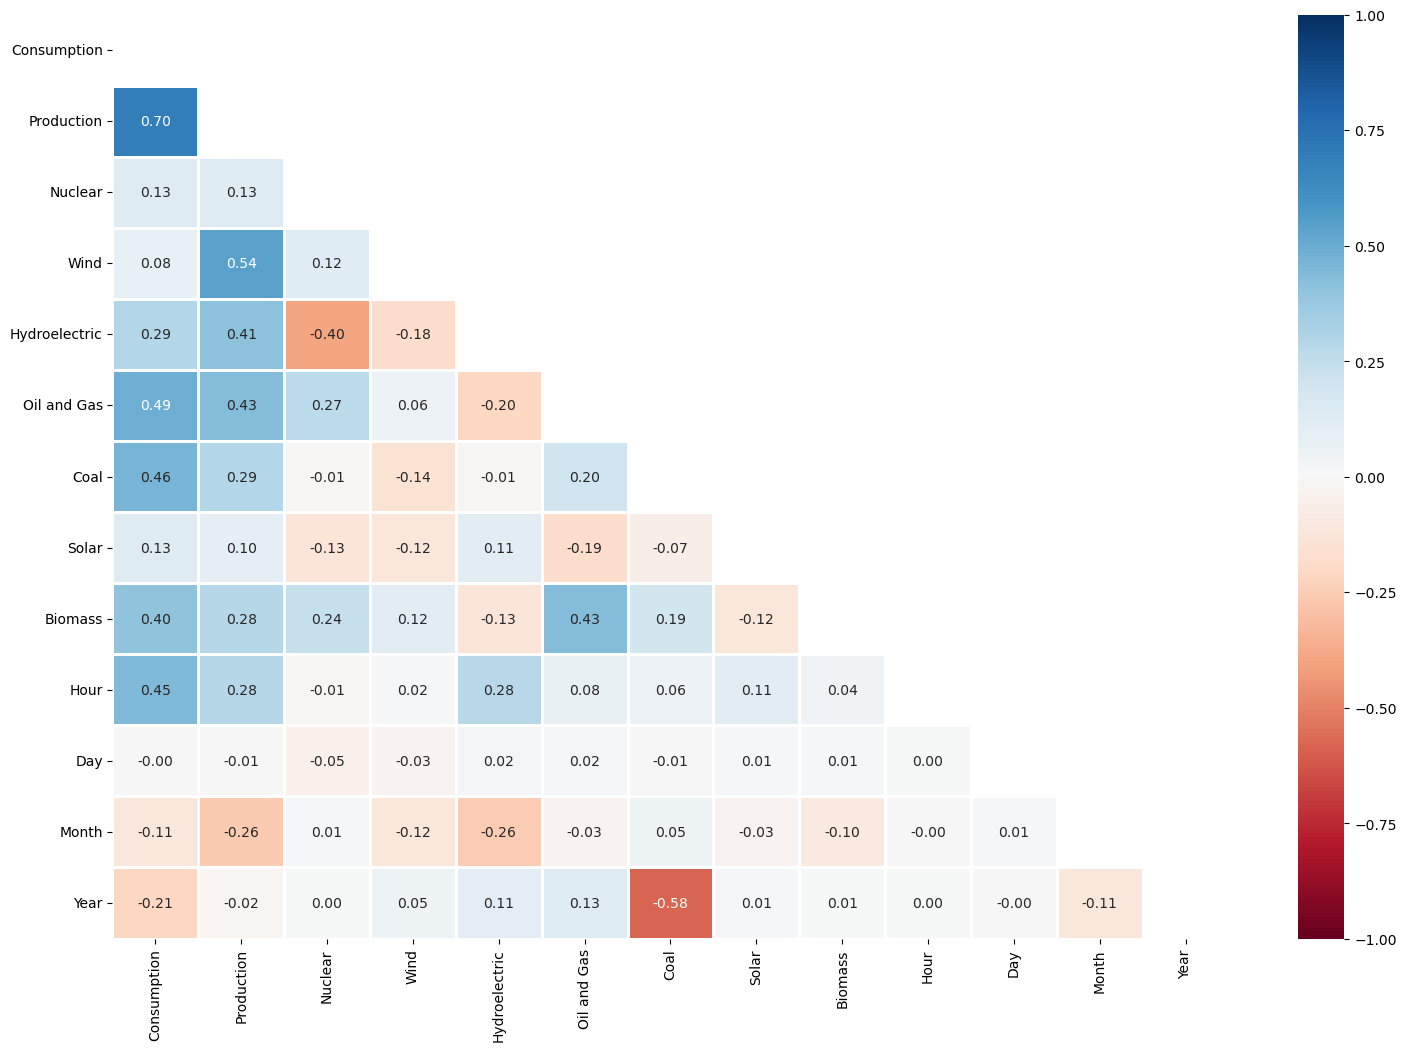

In [19]:
#Create Heatmap excluding object or datetime variables
numeric = df.select_dtypes(['int'])
plt.figure(figsize=(18,12))
mask = np.triu(np.ones_like(numeric.corr(), dtype=bool))
sns.heatmap(numeric.corr(), mask=mask, center=0, cmap='RdBu', linewidths=1, annot=True, fmt=".2f", vmin=-1, vmax=1)

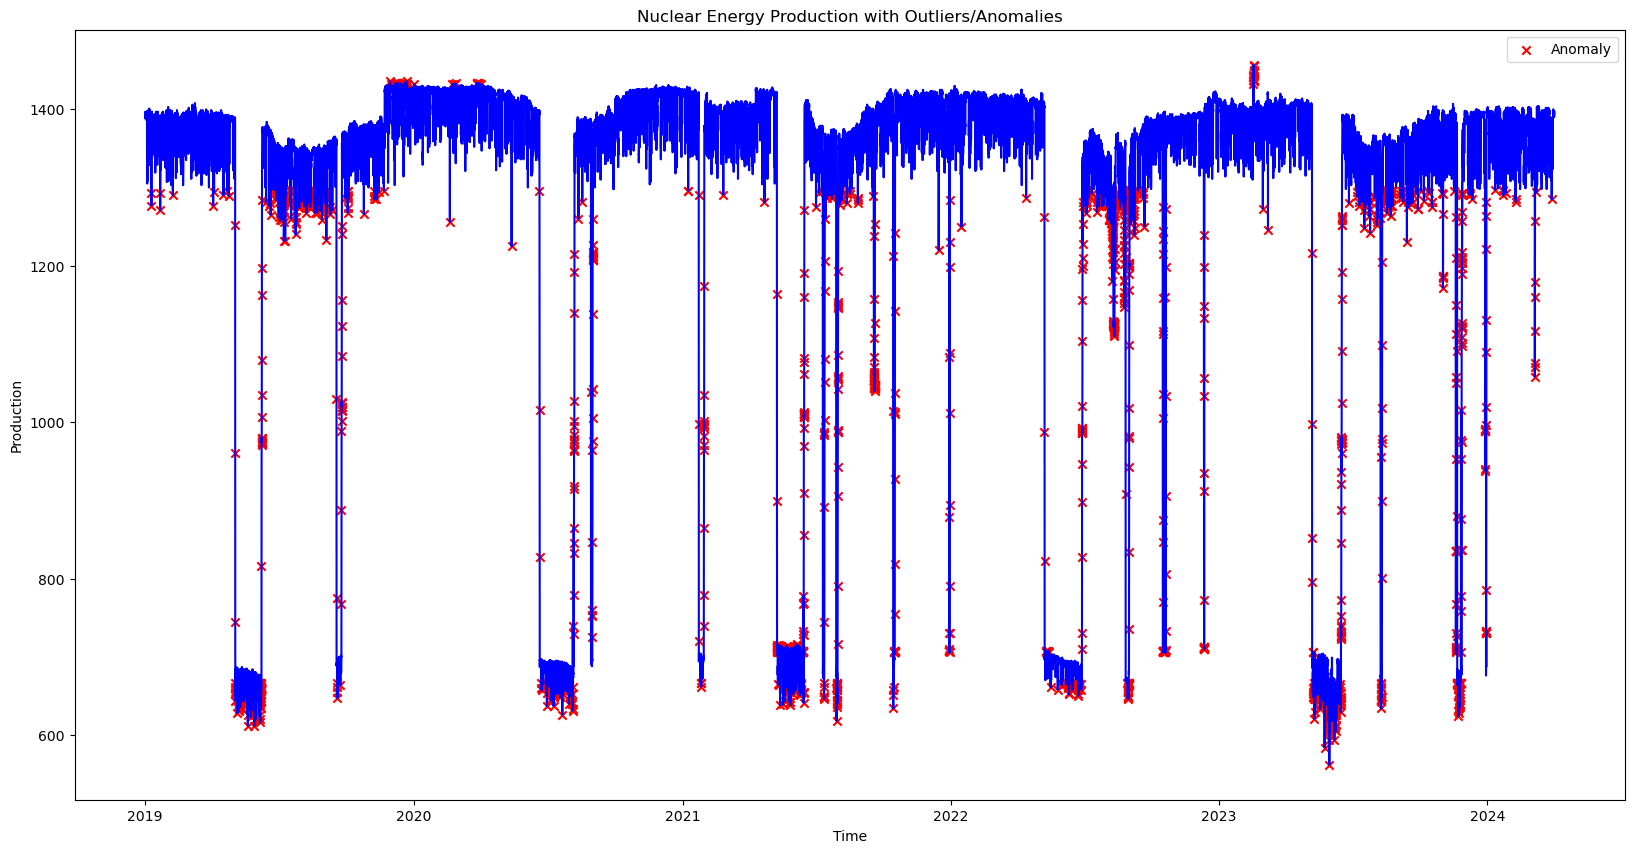

In [20]:
# Fit the IsolationForest model
iso_forest = IsolationForest(contamination=0.05)
df['anomaly'] = iso_forest.fit_predict(df[['Nuclear']])

# The 'anomaly' column will have values 1 (normal) and -1 (anomaly)
anomalies = df[df['anomaly'] == -1]

# Plot the original data
plt.figure(figsize=(20, 10))
plt.plot(df['DateTime'], df['Nuclear'], label='', color='blue')

# Overlay the anomalies on the plot
plt.scatter(anomalies['DateTime'], anomalies['Nuclear'], color='red', label='Anomaly', marker='x')

#Give it a title and annotate the axis
plt.title('Nuclear Energy Production with Outliers/Anomalies')
plt.xlabel('Time')
plt.ylabel('Production')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Autocorrelation of Nuclear Energy')

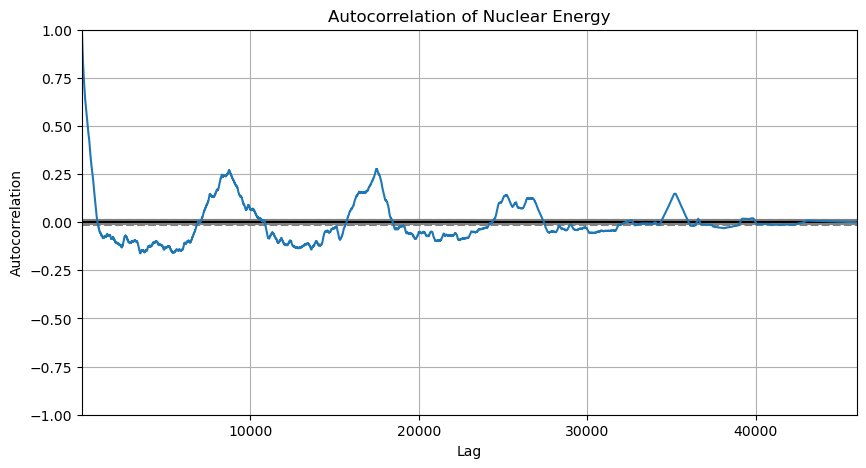

In [21]:
#Autocorrelation of Nuclear Energy
plt.figure(figsize=(10, 5))
autocorrelation_plot(df['Nuclear'])
plt.title('Autocorrelation of Nuclear Energy')

Text(0.5, 1.0, 'Autocorrelation of Hydroelectric Energy')

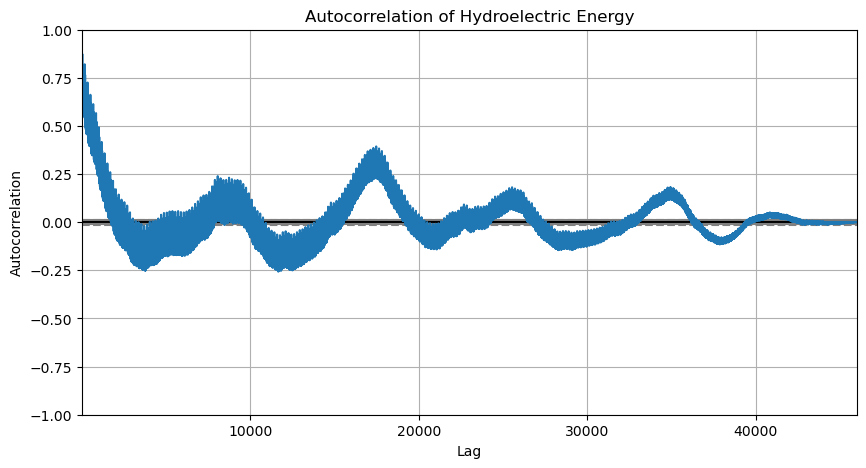

In [22]:
#Autocorrelation of Hydroelectric Energy
plt.figure(figsize=(10, 5))
autocorrelation_plot(df['Hydroelectric'])
plt.title('Autocorrelation of Hydroelectric Energy')

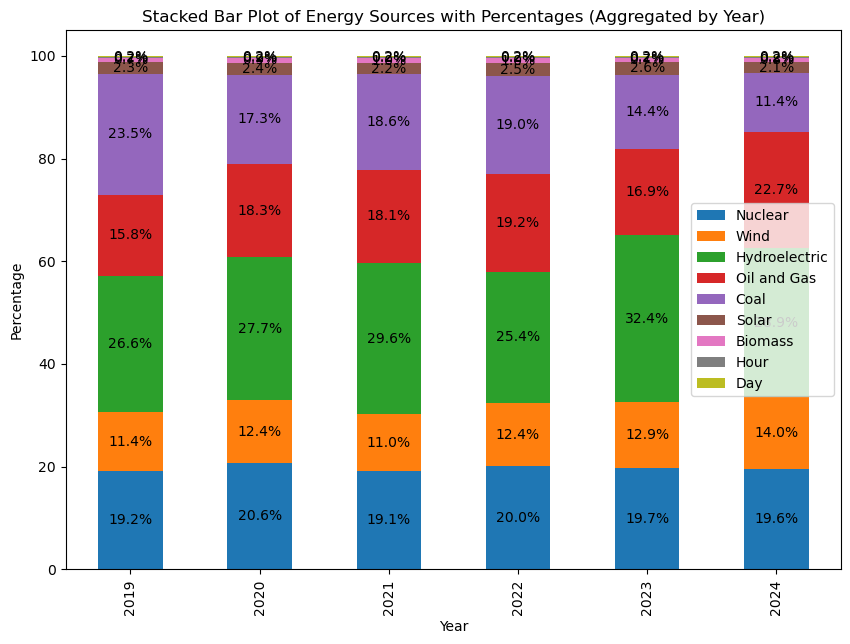

In [23]:
#create new df by dropping unnecessary columns
energy_df = df.drop(columns=['Month','Export/Import','Production','Consumption', 'DateTime','anomaly'])

# Assuming 'energy_df' is your DataFrame after dropping unnecessary columns
aggregated_df = energy_df.groupby('Year').sum()

# Normalize the aggregated data to percentages
aggregated_df_percentage = aggregated_df.div(aggregated_df.sum(axis=1), axis=0) * 100

# Plotting
ax = aggregated_df_percentage.plot(kind='bar', stacked=True, figsize=(10, 7))

# Adding percentages on top of the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center')

plt.ylabel('Percentage')
plt.title('Stacked Bar Plot of Energy Sources with Percentages (Aggregated by Year)')
plt.legend()
plt.show()

## Modelling

In [24]:
#Drop unnecessary varibales for my model
df = df.drop(['DateTime','Export/Import','anomaly'],axis=1)

In [25]:
# Select features to scale
features = ['Consumption', 'Production', 'Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass','Day','Hour','Month','Year']
scaler = MinMaxScaler()

# Fit the scaler on the dataset and transform
scaled_features = scaler.fit_transform(df[features])


# Convert to DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=features)

In [26]:
#define a window/sequence  function that takes two arguments:  the dataframe and the window/sequence size
def window_func(df, window_size):
    #convert the features and the labels into a numpy array
    df_np = df.to_numpy()
    label_numpy = df[['Consumption','Production']].to_numpy()
    #initialize empty list for features and label 
    X=[]
    y=[]
    #iterate over the dataframe stopping the window size rows before the end
    for i in range(len(df_np)-window_size):
        # For each iteration, a slice of df_np is taken from index i to i + window_size. Each element a in this slice is converted into a list of lists
        row = [[a] for a in df_np[i:i+window_size]]
        #The created window row is appended to the X list.
        X.append(row)
        # Consumption and Production  at index i + window_size is selected from label_numpy
        label = label_numpy[i+window_size]
        #The selected label is appended to the y list
        y.append(label)
    #convert list to numpy arrays
    X, y = np.array(X), np.array(y)
    return X,y

In [27]:
#Window size or Sequence lenght : here we choose 24hours or a complete day, meaning the  model will use the data from the past 24 hours (e.g., consumption from 1 PM the previous day to 12 PM today) to predict the consumption at 1 PM today
window = 24
X, y = window_func(scaled_df, window)

In [28]:
#train test split with a test size of 0.2, shuffle = False to avoid data leakage 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=False)

In [29]:
#check the dimension of my train test
X_train.shape

(36786, 24, 1, 13)

In [30]:
#reshape data into 3d
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[3]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[3]))

In [31]:
#initialize a sequential model
model = Sequential()

#create a simple RNN , the input shape is the sequence lenght and the number of features
model.add(SimpleRNN(100, input_shape=(window, X_train.shape[2]),return_sequences=True))
#second layer
model.add(SimpleRNN(100))
#dense layer with two output
model.add(Dense(2))

#compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [32]:
#summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 24, 100)           11400     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100)               20100     
                                                                 
 dense (Dense)               (None, 2)                 202       
                                                                 
Total params: 31702 (123.84 KB)
Trainable params: 31702 (123.84 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
#initiale an early stop, this helps in preventing overfitting
early_stop = EarlyStopping(monitor='val_loss',patience=5)
#fit the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, callbacks=[early_stop], validation_data=(X_test, y_test))


Epoch 1/20

1150/1150 [==============================] - 20s 14ms/step - loss: 0.0035 - val_loss: 0.0015
Epoch 2/20
1150/1150 [==============================] - 16s 14ms/step - loss: 0.0011 - val_loss: 7.8885e-04
Epoch 3/20
1150/1150 [==============================] - 16s 14ms/step - loss: 8.9837e-04 - val_loss: 0.0010
Epoch 4/20
1150/1150 [==============================] - 15s 13ms/step - loss: 7.9221e-04 - val_loss: 9.2473e-04
Epoch 5/20
1150/1150 [==============================] - 17s 15ms/step - loss: 7.7915e-04 - val_loss: 7.0938e-04
Epoch 6/20
1150/1150 [==============================] - 16s 14ms/step - loss: 7.5776e-04 - val_loss: 7.6719e-04
Epoch 7/20
1150/1150 [==============================] - 16s 14ms/step - loss: 6.9992e-04 - val_loss: 7.9872e-04
Epoch 8/20
1150/1150 [==============================] - 15s 13ms/step - loss: 6.9740e-04 - val_loss: 0.0011
Epoch 9/20
1150/1150 [==============================] - 16s 14ms/step - loss: 6.6977e-04 - val_loss: 0.0014
Epoch 10/20
115

In [35]:
# Split into consumption and production arrays
rnn_predictions = model.predict(X_test)
y_test_consumption = y_test[:, 0]
y_test_production = y_test[:, 1]
y_pred_consumption = rnn_predictions[:, 0]
y_pred_production = rnn_predictions[:, 1]

# Calculate metrics for Consumption
r2_consumption = r2_score(y_test_consumption, y_pred_consumption)
mae_consumption = mean_absolute_error(y_test_consumption, y_pred_consumption)
mse_consumption = mean_squared_error(y_test_consumption, y_pred_consumption)
rmse_consumption = np.sqrt(mse_consumption)

# Calculate metrics for Production
r2_production = r2_score(y_test_production, y_pred_production)
mae_production = mean_absolute_error(y_test_production, y_pred_production)
mse_production = mean_squared_error(y_test_production, y_pred_production)
rmse_production = np.sqrt(mse_production)

# Print results
print(f"Consumption - R² Score: {r2_consumption}")
print(f"Consumption - MAE: {mae_consumption}")
print(f"Consumption - MSE: {mse_consumption}")
print(f"Consumption - RMSE: {rmse_consumption}\n")

print(f"Production - R² Score: {r2_production}")
print(f"Production - MAE: {mae_production}")
print(f"Production - MSE: {mse_production}")
print(f"Production - RMSE: {rmse_production}")

288/288 [==============================] - 4s 7ms/step
Consumption - R² Score: 0.9822945227524135
Consumption - MAE: 0.017207823926106463
Consumption - MSE: 0.00047300998626048966
Consumption - RMSE: 0.021748792754093034

Production - R² Score: 0.9556490526689249
Production - MAE: 0.021028632151924655
Production - MSE: 0.0008356293923032189
Production - RMSE: 0.028907255011557546


Text(0.5, 1.0, 'Training Loss vs Validation Loss')

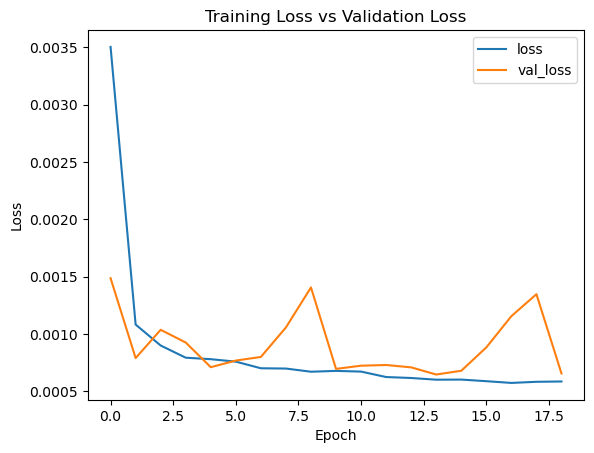

In [36]:
#plot training and validation loss
losses = pd.DataFrame(history.history)
losses.plot()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training Loss vs Validation Loss')

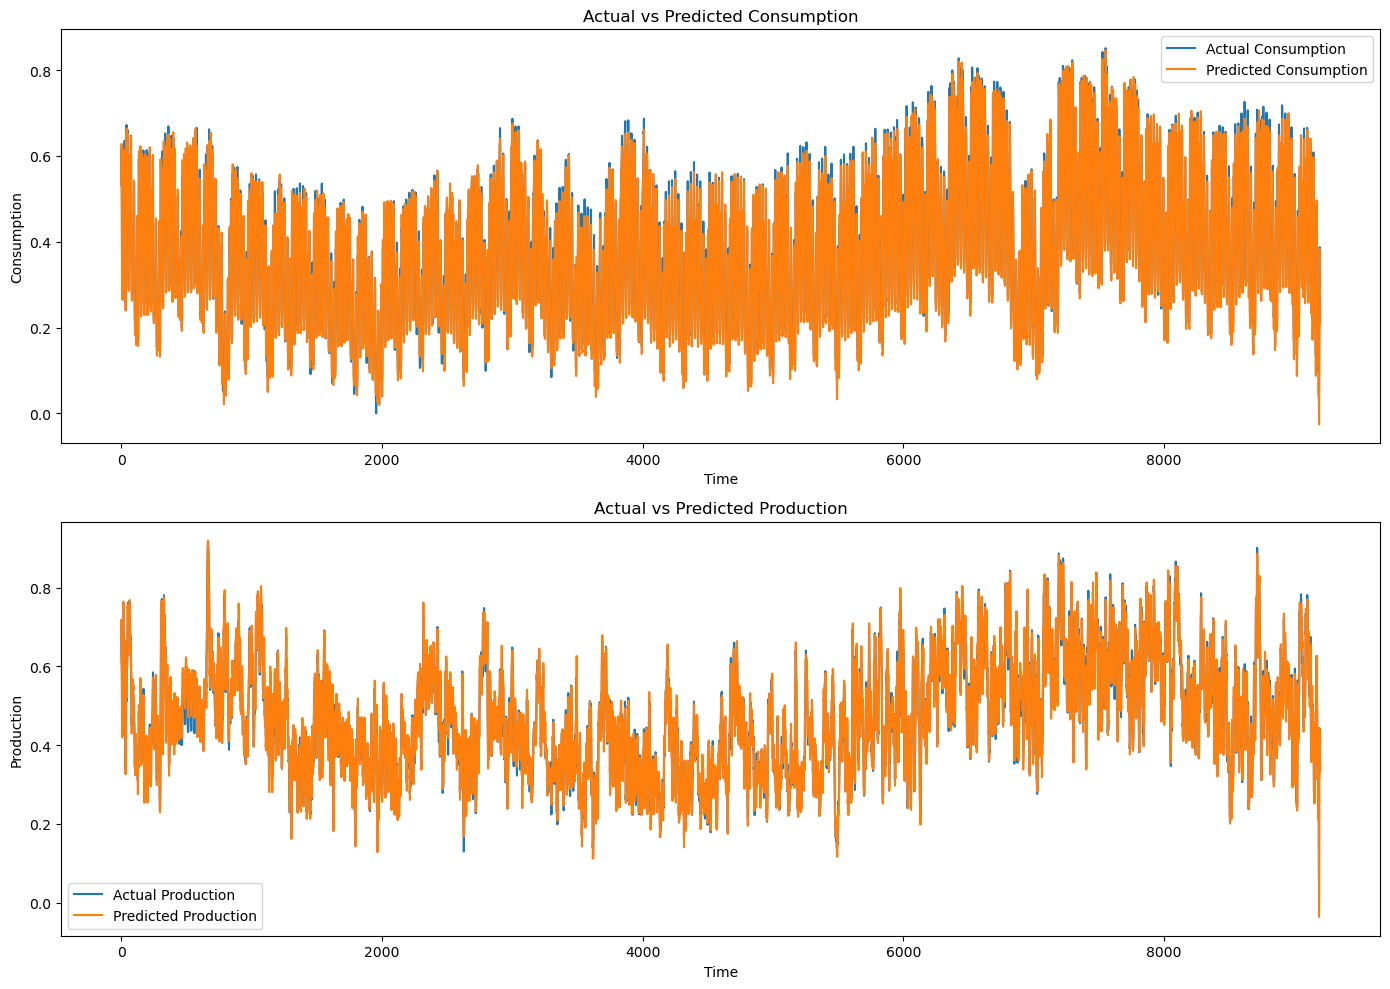

In [37]:
# Create subplots
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

# Plot Consumption
ax[0].plot(y_test[:, 0], label='Actual Consumption')
ax[0].plot(rnn_predictions[:, 0], label='Predicted Consumption')
ax[0].set_title('Actual vs Predicted Consumption')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Consumption')
ax[0].legend()

# Plot Production
ax[1].plot(y_test[:, 1], label='Actual Production')
ax[1].plot(rnn_predictions[:, 1], label='Predicted Production')
ax[1].set_title('Actual vs Predicted Production')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Production')
ax[1].legend()

# Display the plots
plt.tight_layout()
plt.show()


In [38]:
#create the LSTM Model
model2 = Sequential()

model2.add(LSTM(100, input_shape=(window, X_train.shape[2]),return_sequences=True))
Dropout(0.2),
model2.add(LSTM(100))
Dropout(0.2),
model2.add(Dense(2))

model2.compile(optimizer='adam', loss='mean_squared_error')

In [39]:
#fit the LSTM model
early_stop = EarlyStopping(monitor='val_loss',patience=10, restore_best_weights=True)
history2 = model2.fit(X_train, y_train, epochs=20, batch_size=32, callbacks=[early_stop], validation_data=(X_test, y_test))

Epoch 1/20
1150/1150 [==============================] - 46s 34ms/step - loss: 0.0041 - val_loss: 0.0015
Epoch 2/20
1150/1150 [==============================] - 39s 34ms/step - loss: 9.1962e-04 - val_loss: 0.0010
Epoch 3/20
1150/1150 [==============================] - 40s 35ms/step - loss: 7.1774e-04 - val_loss: 8.5652e-04
Epoch 4/20
1150/1150 [==============================] - 44s 38ms/step - loss: 6.3469e-04 - val_loss: 6.4050e-04
Epoch 5/20
1150/1150 [==============================] - 43s 38ms/step - loss: 6.1508e-04 - val_loss: 8.7936e-04
Epoch 6/20
1150/1150 [==============================] - 46s 40ms/step - loss: 5.8493e-04 - val_loss: 6.5073e-04
Epoch 7/20
1150/1150 [==============================] - 41s 36ms/step - loss: 5.6586e-04 - val_loss: 6.6266e-04
Epoch 8/20
1150/1150 [==============================] - 41s 36ms/step - loss: 5.4503e-04 - val_loss: 6.2093e-04
Epoch 9/20
1150/1150 [==============================] - 43s 37ms/step - loss: 5.1632e-04 - val_loss: 6.3898e-04
Epoc

Text(0.5, 1.0, 'Training Loss vs Validation Loss for LSTM Model')

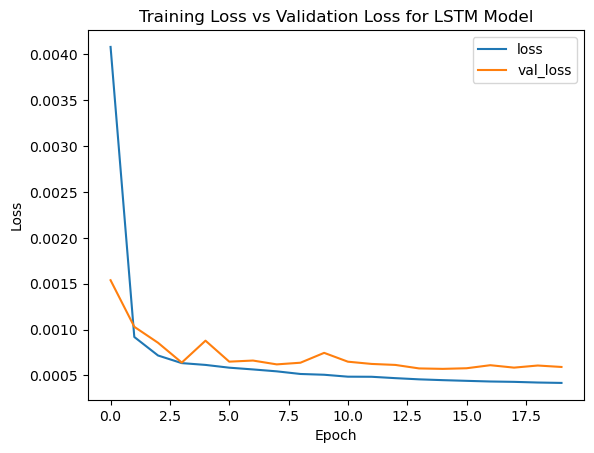

In [40]:
losses = pd.DataFrame(history2.history)
losses.plot()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training Loss vs Validation Loss for LSTM Model')

288/288 [==============================] - 5s 13ms/step


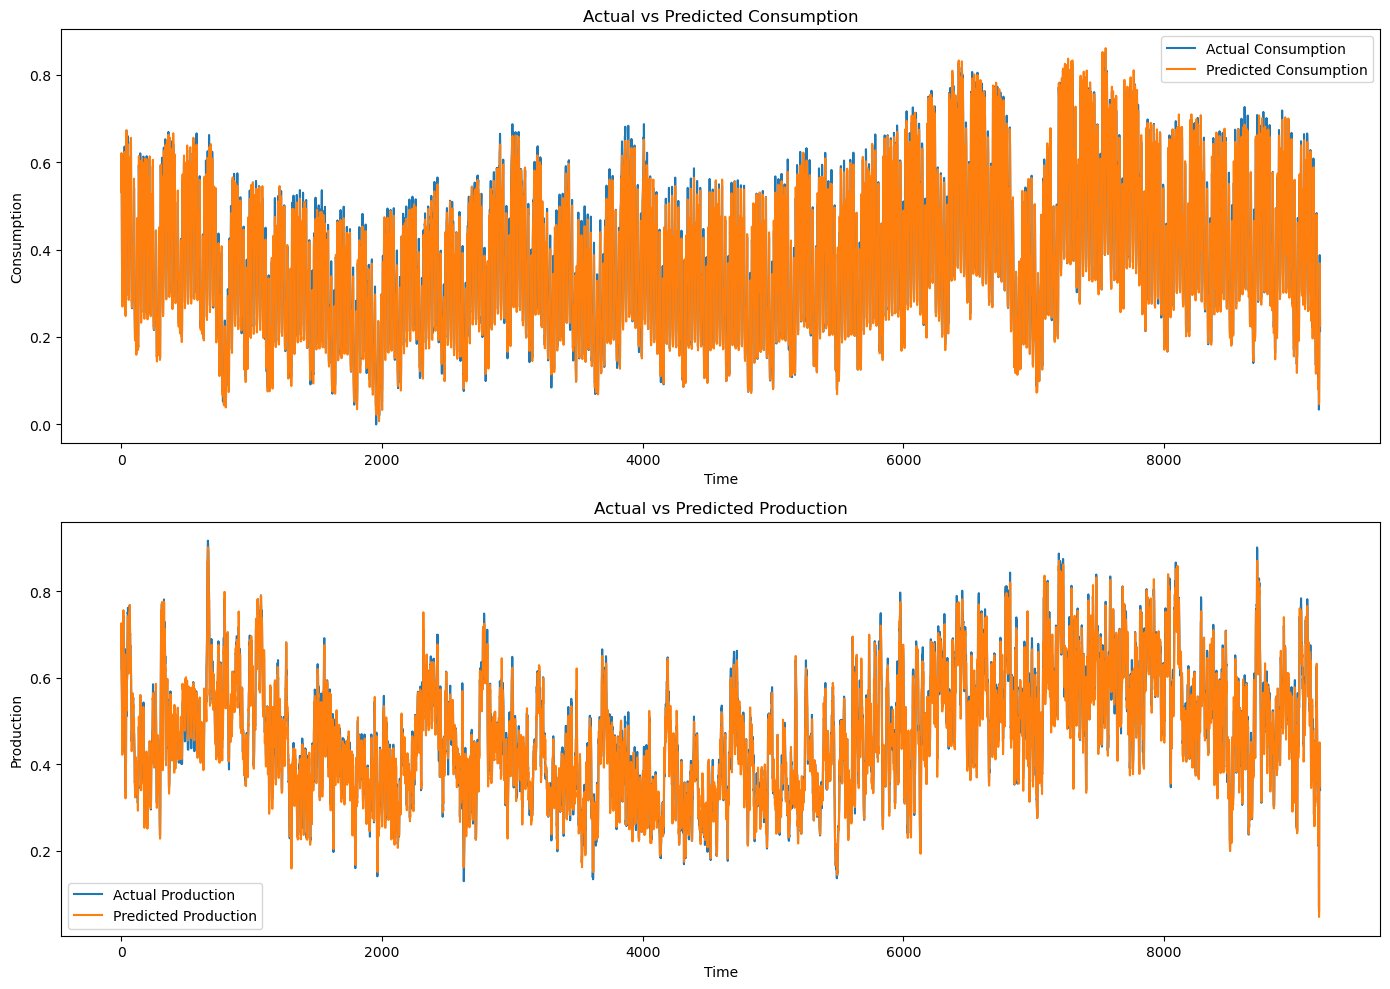

In [42]:
rnn_pred = model2.predict(X_test)
# Create subplots
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

# Plot Consumption
ax[0].plot(y_test[:, 0], label='Actual Consumption')
ax[0].plot(rnn_pred[:, 0], label='Predicted Consumption')
ax[0].set_title('Actual vs Predicted Consumption')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Consumption')
ax[0].legend()

# Plot Production
ax[1].plot(y_test[:, 1], label='Actual Production')
ax[1].plot(rnn_pred[:, 1], label='Predicted Production')
ax[1].set_title('Actual vs Predicted Production')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Production')
ax[1].legend()

# Display the plots
plt.tight_layout()
plt.show()

In [43]:
# Split into consumption and production arrays
y_test_consumption = y_test[:, 0]
y_test_production = y_test[:, 1]
y_pred_consumption = rnn_pred[:, 0]
y_pred_production = rnn_pred[:, 1]

# Calculate metrics for Consumption
r2_consumption = r2_score(y_test_consumption, y_pred_consumption)
mae_consumption = mean_absolute_error(y_test_consumption, y_pred_consumption)
mse_consumption = mean_squared_error(y_test_consumption, y_pred_consumption)
rmse_consumption = np.sqrt(mse_consumption)

# Calculate metrics for Production
r2_production = r2_score(y_test_production, y_pred_production)
mae_production = mean_absolute_error(y_test_production, y_pred_production)
mse_production = mean_squared_error(y_test_production, y_pred_production)
rmse_production = np.sqrt(mse_production)

# Print results
print(f"Consumption - R² Score: {r2_consumption}")
print(f"Consumption - MAE: {mae_consumption}")
print(f"Consumption - MSE: {mse_consumption}")
print(f"Consumption - RMSE: {rmse_consumption}\n")

print(f"Production - R² Score: {r2_production}")
print(f"Production - MAE: {mae_production}")
print(f"Production - MSE: {mse_production}")
print(f"Production - RMSE: {rmse_production}")

Consumption - R² Score: 0.9847620181486872
Consumption - MAE: 0.015585195729585688
Consumption - MSE: 0.0004070897093219864
Consumption - RMSE: 0.02017646424232914

Production - R² Score: 0.9586905784689019
Production - MAE: 0.02045917529860002
Production - MSE: 0.0007783230999046227
Production - RMSE: 0.02789844260715323
